In [38]:
#load audio files 
import os
import numpy as np
from chord_extractor.extractors import Chordino

def load_audio_files(path):
    audio_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".mp3"):
                audio_files.append(os.path.join(root, file))
    return audio_files

In [39]:
path = '/home/laura/aimir/suno/audio'
#path = '/home/laura/aimir/boomy/audio'
path = '/home/laura/aimir/lastfm/audio'
files = load_audio_files(path)

In [40]:
myFiles = files[:10]

In [55]:
from chord_extractor.extractors import Chordino

chordino = Chordino(roll_on=2, spectral_shape=0.5)

In [69]:
id = 2
song = myFiles[id]
id_file = '00c9ce78ee8d7af5586d8148554b2e8c'
song = "/home/laura/aimir/lastfm/audio/" + id_file + ".mp3"
chords = chordino.extract(song)

chords

[ChordChange(chord='N', timestamp=0.371519274),
 ChordChange(chord='Bbmaj7', timestamp=2.4148752829999998),
 ChordChange(chord='Bb', timestamp=3.808072562),
 ChordChange(chord='F', timestamp=6.037188208),
 ChordChange(chord='Bbmaj7', timestamp=7.337505668),
 ChordChange(chord='Bb', timestamp=8.637823129000001),
 ChordChange(chord='Bb6', timestamp=14.675011337),
 ChordChange(chord='F', timestamp=16.811247165),
 ChordChange(chord='Bb', timestamp=19.411882086),
 ChordChange(chord='F', timestamp=20.43356009),
 ChordChange(chord='Bb', timestamp=21.919637188),
 ChordChange(chord='Bb6', timestamp=24.42739229),
 ChordChange(chord='F', timestamp=26.563628117),
 ChordChange(chord='Bb', timestamp=28.885623582),
 ChordChange(chord='F', timestamp=30.093061224),
 ChordChange(chord='Bb6', timestamp=31.393378683999998),
 ChordChange(chord='Bb', timestamp=33.901133786),
 ChordChange(chord='Aaug', timestamp=37.244807256),
 ChordChange(chord='Bb6', timestamp=37.709206349),
 ChordChange(chord='Eb', timest

In [70]:
#print metadata
path = '/home/laura/aimir/lastfm/metadata'
md = path + '/' + id_file + '.json'
import json
with open(md) as json_file:
    data = json.load(json_file)
    for line in data:
        print(line, data[line])

id_dataset 00c9ce78ee8d7af5586d8148554b2e8c
id_spotify 2Vw4bLczjnK1EYayXJgRUu
url_spotify_preview https://p.scdn.co/mp3-preview/718e0505aa796d4a9d3137c5edb60fa9e8f1b976?cid=774b29d4f13844c495f206cafdad9c86
url_lastfm https://www.last.fm/music/The+Tallest+Man+on+Earth/_/Little+River
artist The Tallest Man on Earth
name Little River
youtube_url https://www.youtube.com/watch?v=tZaOSoh-Q1k
tags ['acoustic', 'folk', 'singer-songwriter']
duration 227.682993


In [71]:
#Visualize the chords over the song
import matplotlib.pyplot as plt
import librosa
import librosa.display
from collections import namedtuple, defaultdict

# Load the audio file
y, sr = librosa.load(song)

# Create the plot
plt.figure(figsize=(30, 5))
librosa.display.waveshow(y, sr=sr)

font = {'family' : 'Helvetica',
        'weight' : 'light',
        'size'   : 16}
plt.rc('font', **font)

# Plot vertical lines for each chord change
for chord in chords:
    plt.axvline(x=chord.timestamp, color='r', linestyle='--')
    plt.text(chord.timestamp, max(y), chord.chord, rotation=45, verticalalignment='bottom')

# Display the plot
plt.show()

from IPython.display import Audio
Audio(song)

In [ ]:
def find_repeating_patterns(chords, min_length=5):
    patterns = defaultdict(list)
    for length in range(min_length, len(chords) // 2):
        for i in range(len(chords) - length + 1):
            pattern = tuple(chord.chord for chord in chords[i:i + length])
            patterns[pattern].append(i)
    return patterns

def find_common_patterns(chords, min_length=5, threshold=2):
    patterns = find_repeating_patterns(chords, min_length)
    common_patterns = {pattern: indices for pattern, indices in patterns.items() if len(indices) >= threshold}
    return common_patterns

def detect_sections(chords, min_length=5, threshold=2):
    common_patterns = find_common_patterns(chords, min_length, threshold)
    sections = []
    used_indices = set()

    for pattern, indices in sorted(common_patterns.items(), key=lambda x: -len(x[1])):
        for start in indices:
            end = start + len(pattern)
            if not any(i in used_indices for i in range(start, end)):
                sections.append((start, end, pattern))
                used_indices.update(range(start, end))

    sections.sort()
    return sections

def label_sections(chords, sections):
    section_labels = []
    current_section = 0
    section_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    section_mapping = {}
    
    for i, chord in enumerate(chords):
        while current_section < len(sections) and i >= sections[current_section][1]:
            current_section += 1
        
        if current_section < len(sections) and sections[current_section][0] <= i < sections[current_section][1]:
            section_name = section_mapping.setdefault(sections[current_section][2], section_names[len(section_mapping) % len(section_names)])
            section_labels.append((chord.timestamp, chord.chord, section_name))
        else:
            section_labels.append((chord.timestamp, chord.chord, "Transition"))
    
    return section_labels

In [ ]:
# Detect sections based on repeating patterns
sections = detect_sections(chords)

# Label sections
labeled_sections = label_sections(chords, sections)

# Display labeled sections
for timestamp, chord, label in labeled_sections:
    print(f"{timestamp:.3f} - {chord} - {label}")

0.372 - N - Transition
0.464 - C - A
11.331 - Bbmaj7 - A
12.817 - C - A
24.056 - Bbmaj7 - A
25.542 - C - A
36.780 - Bbmaj7 - A
38.359 - C - A
49.505 - Bbmaj7 - A
50.991 - C - Transition
62.229 - Bbmaj7 - Transition
63.623 - C - Transition
73.654 - F - Transition
75.047 - C - Transition
85.264 - Bbmaj7 - Transition
86.378 - C7 - Transition
88.143 - Gm7 - Transition
89.258 - C7 - Transition
96.409 - Bbmaj7 - Transition
97.710 - C - Transition
103.561 - C7 - Transition
105.511 - C - Transition
107.741 - F - Transition
109.041 - C - A
114.614 - Bbmaj7 - A
116.193 - C - A
127.524 - Bbmaj7 - A
128.917 - C - A
140.249 - Bbmaj7 - A
141.735 - C - A
153.066 - Bbmaj7 - A
154.459 - C - Transition
165.698 - Bbmaj7 - Transition
167.091 - C - Transition
177.122 - Fmaj7 - Transition
178.329 - C - Transition
187.710 - C7 - Transition
195.419 - C - Transition
199.134 - F6 - Transition
201.456 - C - Transition
211.116 - Fmaj7 - Transition
212.416 - C - Transition
268.330 - F - Transition
269.351 - C - Tr

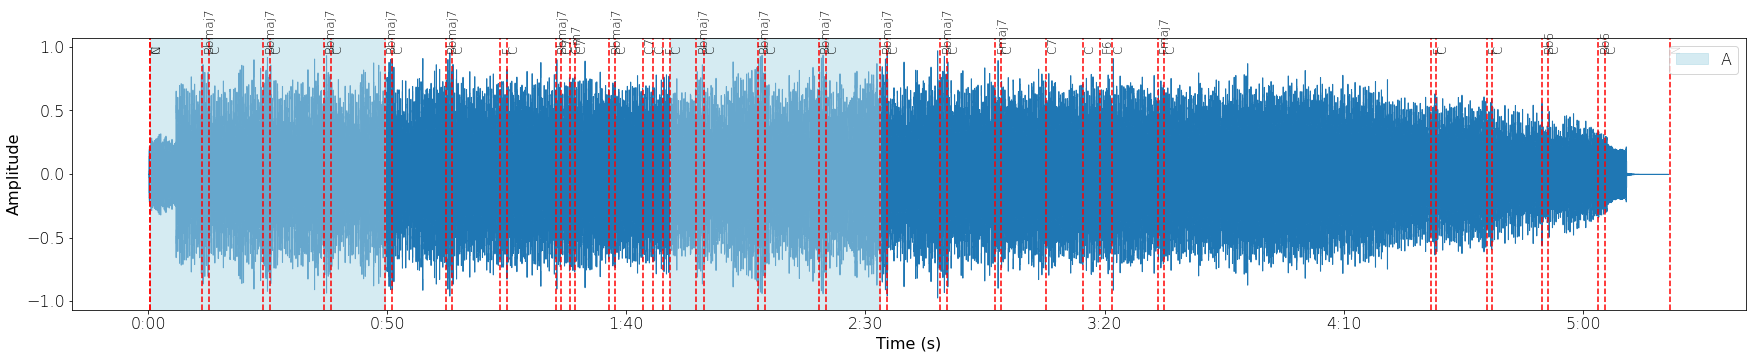

In [ ]:
# Create the plot
plt.figure(figsize=(30, 5))
librosa.display.waveshow(y, sr=sr)

# Define section names and their corresponding colors
section_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
section_colors = {
    'A': 'lightblue',
    'B': 'cyan',
    'C': '#0890ff',
    'D': '#ff00f2',
    'E': '#ffd608',
    'F': 'orange',
    'G': 'blue',
    'H': 'grey',
    'Transition': 'grey'
}

# Plot vertical lines for each chord change and annotate sections
for timestamp, chord, label in labeled_sections:
    plt.axvline(x=timestamp, color='r', linestyle='--')
    plt.text(timestamp, max(y), chord, rotation=90, verticalalignment='bottom', fontsize=12)

# Highlight sections
for start, end, pattern in sections:
    # Use the section name from the labeled sections
    section_name = labeled_sections[start][2]
    color = section_colors[section_name]  # Get color for the section
    plt.axvspan(chords[start].timestamp, chords[end - 1].timestamp, color=color, alpha=0.5, label=section_name)

# Remove duplicates in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

# Display the plot
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()
